# ABIDE Subtype analysis

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 7
name = 'n308_sample'
mtp_list= ['rmap_part', 'dual_regression', 'stability_maps']
mtp = mtp_list[0]

in_default = '{}_{}_scale_{:03d}'.format(mtp, name, scale)

prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

## Build the subtypes and compute the weights

In [10]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [11]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [12]:
netraw = np.load(netraw_path)

In [13]:
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [14]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [15]:
print('{} has {}'.format(cov, np.sum(cov_index)))

DX_GROUP has 308


In [16]:
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

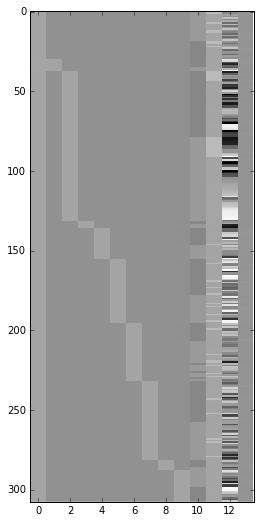

In [33]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [34]:
cov_weight = weight_store[..., cov_index.values]

In [35]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

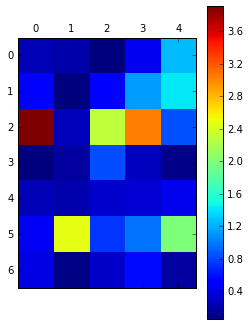

In [36]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

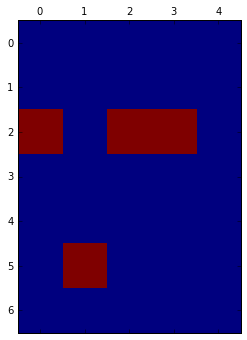

In [37]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [38]:
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [39]:
def show_simple(net_id, sbt_id, gdavg_img, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

In [40]:
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]

## ADOS

### Network 1

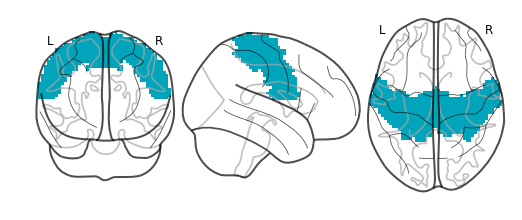

In [41]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 2), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos

In [42]:
print(res_store[2][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.345
Date:                Fri, 13 Nov 2015   Prob (F-statistic):           1.22e-08
Time:                        15:33:07   Log-Likelihood:                -3.4934
No. Observations:                 308   AIC:                             34.99
Df Residuals:                     294   BIC:                             87.21
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1270      0.099      1.288      

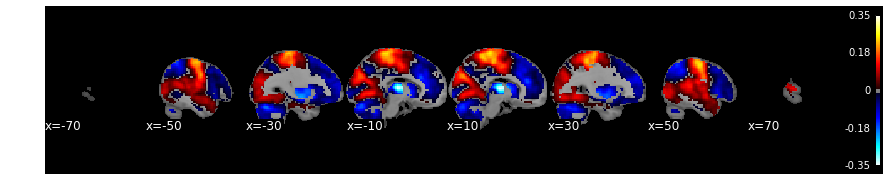

In [43]:
tmp = show_simple(2,0,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg

In [44]:
print(res_store[2][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     4.603
Date:                Fri, 13 Nov 2015   Prob (F-statistic):           3.35e-07
Time:                        15:33:26   Log-Likelihood:                 76.460
No. Observations:                 308   AIC:                            -124.9
Df Residuals:                     294   BIC:                            -72.70
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0694      0.076      0.912      

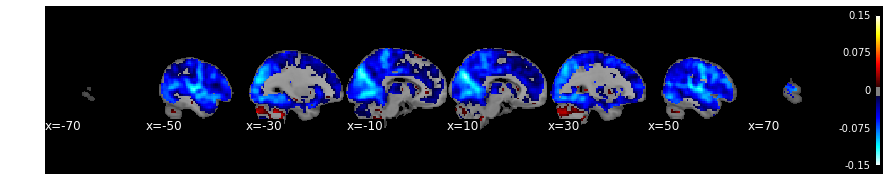

In [45]:
tmp = show_simple(2,2,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)